Lecture 1
=========
## Molecular dynamics simulations

Molecular dynamics simulations typically refere to computer simulations of molecular motion. We are mainly going to discuss classical reactive molecular
dynamics in this class. The classical part of this name referes to emipirical potentials that drive the motion of atoms using Newtons classical laws of 
motion. These empirical potentials can either describe non-reactive or reactive processes governed by molecular motion. We are largely going to stick to
reactive molecular molecular dynamics simulations, specifically ReaxFF potential. 

Chemical reactive events are ubiquitous in nature. These events govern many aspects of our lives, from energy generating combustion reactions to 
metabolism. These events span several thermodynamic and time scales. Computationally studying and modelling these reaction events is a major asset
 in our quest to understand the world that we live in. A variety of methods, ranging from the quantum chemistry studies of reactions to continuum 
scale simulations of reactive processes, are available to study reaction chemistry. The first principle or quantum chemistry (QC) methods delve into 
the atomic world, describing electronic structures and associated useful properties used to characterize a reaction event. However, these methods 
become computationally untenable for the scale of several hundreds of atoms even with the best current computational resources. On the other end of 
size spectrum are continuum scale computational fluid dynamics simulations (CFD). These can simulate much larger scale processes such as the combustion
 in an automobile engine [1], which involves fluid mechanics as well as reactions chemistry processes. However, the CFD simulations typically involve
 only a simplified description of reactive events in the form of lumped or abbreviated reaction mechanisms.

Reactive force field methods bridge the gap between the first principle and CFD methods. These methods deploy connection-dependent interatomic 
potentials to calculate system energy as a function of atomic positions. In the ReaxFF reactive force field method, the interatomic potential describes 
reactive events through a bond-order formalism, where bond order is empirically calculated from interatomic distances. The interatomic potentials 
are trained using the QC data. Electronic interactions driving chemical bonding are treated implicitly, allowing the method to simulate reaction 
chemistry without explicit QC consideration. This puts ReaxFF in a unique position to simulate reaction dynamics of systems involving thousands of 
molecules while approaching the accuracy of the QC methods.

## What is an interatomic potential?
To understand the atomic motion, we first need to understand the forces and energies among these atoms. Imagine a car driving on a straight road. 
The position of the car as a function of time can be determined using Newtons laws of motion. However, to determine the velocity or acceleration 
of the vehicle, we also need to calculate the energy produced by the engine as a function of time. This energy would be a function of fuel intake, 
wnd resistance and several other factors. Similarly, a molecular dynamics potential defines the energy of the system as a function of interatomic 
distances and configurations. These interatomc potential are the driving engine of the molecular dynamics simulations.

The form of the interatomic potential depends on the application it has been developed for. Let us consider the example of an inert gas. Assume that
we want to model the motion of an inert gas and derive useful properties such as its density as a function of temperature and pressure. Given that 
it is an inert gas, the energy change in the system would mainly originate from the atoms moving close and away from each other. There are not 
reactions happening among the molecules. If we don't want to simulate high temperatures where the atoms break apart forming plasma, we would need 
an expression describing energy of a system of two atoms as a function of interatomic distance. The following section reviews one such potential.


### L-J potential

The LJ potential is defined as

$$
V(r)=4\epsilon\left[\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^{6}\right]
$$

Let us plot the LJ potential first

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myst_nb import glue

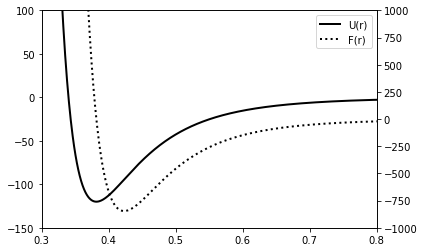

None

In [2]:
# Boltzmann's constant, J/K
kB = 1.381e-23

# The Lennard-Jones parameters:
A = 1.024e-23   # J.nm^6
B = 1.582e-26   # J.nm^12

# Adjust the units of A and B - they have more manageable values
# in K.nm^6 and K.nm^12
A, B = A / kB, B / kB

# Interatomic distance, in nm
r = np.linspace(0.3, 1, 1000)
# Interatomic potential
U = B/r**12 - A/r**6
# Interatomic force
F = 12*B/r**13 - 6*A/r**7

line1 = plt.plot(r, U, 'k', lw=2, label=r'U(r)')
plt.xlim(0.3, 0.8)
plt.ylim(-150, 100)

plt.twinx()
line2 = plt.plot(r, F, 'k', ls=':', lw=2, label=r'F(r)')
plt.xlim(0.3, 0.8)
plt.ylim(-1000, 1000)

# Jump through some hoops to get the both line's labels in the same legend:
lines = line1 + line2
labels = []
for line in lines:
    labels.append(line.get_label())
plt.legend(lines, labels)

#plt.show()
glue("lj_fig", plt.show(), display=False)

```{glue:figure} lj_fig
:figwidth: 300px
:name: "lj fig"

L-J potential for Ar gas.
```


```{admonition} Exercise 1
Use the code above as an example to plot energy of L-J potentials for He, Ne and Kr. Comment on the comparison.
```

## Anatomy of an MD code

So how do we model the motion of the molecules using the interatomic potential. This task is performed by numerous MD codes (such as LAMMPS), 
most of which have following aspects as a part of them. The codes typically start by intialting positions and velocities for the particles based
on user defined directives. These properties are then used to determine interatomic forces between the particles. The forces,positions and 
velocities are then used to solve Newton's equations of motion numerically. The numerical equation detrmines the updated positions of the particles
after a small but finite time (time-step). The old and new positions can then be used to detrmine the new velocities. This cycle is continued for 
multiple time-steps until the desired properties are obtained. On top this basic structure, MD simulation codes also have ways to impose thermodynamic
conditions on the simulated system through thermostats and barostats, which we will discuss later. What is also clear from this description is that 
all the properties of interest need to be a function of position and velocities of the particles.

```{figure} ./images/MD_structure.png
---
height: 300px
name: directive-fig
---
Simplified structure of a typical MD code.
```



## The MD run


Let us take a look at an example of a LJ potential to model the motion of an inert gas. You will be
able to play with the following code as a part of excersize for this lecture. The code uses ASE to
simulate Ar liquid at 94.4 K using LJ potential. 

> This example has a historical significance. Aneesur Rahman, considered as one of the pioneers of
 molecular dynamics, used similar methods modelling motion of atoms in liquid Argon. This paper is 
generally considered to mark the beginnings of the molecular dynamics method. You can access the 
original paper [here](https://journals.aps.org/pr/abstract/10.1103/PhysRev.136.A405).

In [3]:
from ase import Atoms, units
from ase.visualize import view
from ase.calculators.lj import LennardJones
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory
from ase.optimize.minimahopping import MinimaHopping
from ase_notebook import AseView, ViewConfig, get_example_atoms
from ase.io import read, write, lammpsrun
from ase import units

Let us first define the simulation box geometry.

In [4]:
config = ViewConfig()
ase_view = AseView(config)
atoms=read('/home/al9001/Ar.xyz')
#view(atoms, viewer='ngl')
ase_view.config.canvas_color_background = "blue"
ase_view.config.canvas_background_opacity = 0.2
gui = ase_view.make_render(
    atoms, center_in_uc=True)
gui


/home/al9001/.conda/envs/ase/lib/python3.8/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 298.4792482181195), p…

Run a sample MD simulation.

In [5]:
atoms.calc = LennardJones(sigma=0.34,epsilon=1.657E-21,rc=3.4)
MaxwellBoltzmannDistribution(atoms, temp=0.00814)
T = 94.4  # Kelvin

dyn = Langevin(atoms, 0.1*units.fs, T*units.kB, 0.002)

def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.2feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


dyn.attach(printenergy, interval=50)

# We also want to save the positions of all atoms after every 100th time step.
traj = Trajectory('moldyn3.traj', 'w', atoms)
dyn.attach(traj.write, interval=50)

# Now run the dynamics
printenergy()
dyn.run(200)

Energy per atom: Epot = -0.000eV  Ekin = 0.01eV (T= 91K)  Etot = 0.012eV
Energy per atom: Epot = -0.000eV  Ekin = 0.01eV (T= 91K)  Etot = 0.012eV


Energy per atom: Epot = -0.000eV  Ekin = 0.01eV (T= 91K)  Etot = 0.012eV


Energy per atom: Epot = -0.000eV  Ekin = 0.01eV (T= 91K)  Etot = 0.012eV


Energy per atom: Epot = -0.000eV  Ekin = 0.01eV (T= 91K)  Etot = 0.012eV


Energy per atom: Epot = -0.000eV  Ekin = 0.01eV (T= 92K)  Etot = 0.012eV


True